In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


Implement and test Conditional VAE (cVAE)

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_dim=784, label_dim=10, hidden_dim=400, latent_dim=20):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim + label_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x, y):
        # Flatten image and concatenate one-hot label
        x = torch.cat([x, y], dim=1)
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=20, label_dim=10, hidden_dim=400, output_dim=784):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, y):
        z = torch.cat([z, y], dim=1)
        h = F.relu(self.fc1(z))
        out = torch.sigmoid(self.fc2(h))  # [0, 1] pixel values
        return out

In [4]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

In [5]:
class cVAE(nn.Module):
    def __init__(self):
        super(cVAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x, y):
        mu, logvar = self.encoder(x, y)
        z = reparameterize(mu, logvar)
        recon_x = self.decoder(z, y)
        return recon_x, mu, logvar


In [6]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_loader = DataLoader(datasets.MNIST(root='.', train=True, transform=transform, download=True), batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


100%|██████████| 9.91M/9.91M [00:02<00:00, 3.85MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 210kB/s]
100%|██████████| 1.65M/1.65M [00:05<00:00, 304kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.73MB/s]


In [13]:
for epoch in range(10):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        y_onehot = F.one_hot(y, num_classes=10).float()
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x, y_onehot)
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

Epoch 1, Loss: 102.0983
Epoch 2, Loss: 101.6825
Epoch 3, Loss: 101.3145
Epoch 4, Loss: 101.0319
Epoch 5, Loss: 100.7716
Epoch 6, Loss: 100.4897
Epoch 7, Loss: 100.2922
Epoch 8, Loss: 100.0866
Epoch 9, Loss: 99.8711
Epoch 10, Loss: 99.7335


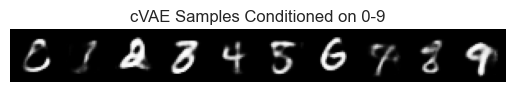

In [18]:
model.eval()
with torch.no_grad():
    y = torch.arange(0, 10)
    y_onehot = F.one_hot(y, num_classes=10).float()
    z = torch.randn(10, 20).to(device)
    samples = model.decoder(z, y_onehot).cpu()
    samples = samples.view(-1, 1, 28, 28)
    grid = make_grid(samples, nrow=10)
    plt.imshow(grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.title("cVAE Samples Conditioned on 0-9")
    plt.show()
